# <font color = blue>**Identify Key Entities in Recipe Data** </font>


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard red chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe
def load_json_dataframe(file_path):
    
    df = pd.read_json(file_path)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
df= load_json_dataframe("ingredient_and_quantity.json")

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df
df.head()

,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [8]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [9]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

def tokenize_text(text):
    return text.split()
    
# Tokenize input
df['input_tokens'] = df['input'].apply(tokenize_text)

# Tokenize POS
df['pos_tokens'] = df['pos'].apply(tokenize_text)

In [11]:
# display first five rows of the dataframe - df
df.head()

,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [13]:
# check for the equality of input_length and pos_length in the dataframe
unequal_rows = df[df['input_length'] != df['pos_length']]
print(f"Number of rows with mismatch: {len(unequal_rows)}")
unequal_rows

Number of rows with mismatch: 5


,input,pos,input_tokens,pos_tokens,input_length,pos_length
17,2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt,quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",15,14
27,1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce,quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, Baguette, sliced, 1, 1/2, tablespoon, Butter, 1/2, Garlic, minced, cup, Spinach, Leaves, Palak, Red, Bell, pepper, Capsicum, Tomato, finely, chopped, Onion, Black, powder, Italian, seasoning, teaspoon, Fresh, cream, Cheddar, cheese, grated, Salt, Roasted, tomato, pasta, sauce]","[quantity, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",37,36
79,1/2 cup Poha Flattened rice 2 tablespoons Rice flour 2 1/2 liter Milk 1 Nolen Gur or brown sugar Cardamom Elaichi Pods/Seeds 8-10 Mixed nuts almonds/cashews tablespoon Raisins pinch Saffron strands and a little more for garnish Salt,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1/2, cup, Poha, Flattened, rice, 2, tablespoons, Rice, flour, 2, 1/2, liter, Milk, 1, Nolen, Gur, or, brown, sugar, Cardamom, Elaichi, Pods/Seeds, 8-10, Mixed, nuts, almonds/cashews, tablespoon, Raisins, pinch, Saffron, strands, and, a, little, more, for, garnish, Salt]","[quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",38,37
164,1/2 cup All Purpose Flour Maida Whole Wheat 1/4 Hung Curd Greek Yogurt 250 grams Chicken minced 1 Spinach Leaves Palak finely chopped Onion 4 cloves Garlic Tomatoes tablespoon Cumin powder Jeera Coriander Powder Dhania 1 1/2 teaspoon Paprika Black pepper 3 sprig Mint Pudina 10 Spring Bulb & Greens 100 Feta Cheese crumbled,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,"[

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [14]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it

def unique_labels(df):
    unique_pos_labels = set()
    for pos in df['pos_tokens']:
        unique_pos_labels.update(pos)  # Add all POS tags from the list to the set
    return sorted(unique_pos_labels)

all_unique_pos_labels = unique_labels(df)
print(f"All Unique POS labels found:{all_unique_pos_labels}")

All Unique POS labels found:['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [15]:
# Find all rows where input_length and pos_length are not equal
unequal_rows = df[df['input_length'] != df['pos_length']]
print(f"Number of rows with mismatch: {len(unequal_rows)}")
index_to_clean = df[df['input_length'] != df['pos_length']].index.tolist()
print(f'Index to clean : {index_to_clean}')

Number of rows with mismatch: 5
Index to clean : [17, 27, 79, 164, 207]


In [16]:
# Finding the index for unequal paranthesis in the input 
# Function to check unequal parentheses
def has_unequal_parentheses(text):
    return text.count('(') != text.count(')')
unequal_param_indices = df[df['input'].apply(has_unequal_parentheses)].index

print("Rows with unequal parentheses:", unequal_param_indices.tolist())

Rows with unequal parentheses: [37]


<font color = green> There are 5 records with indexes as [17, 27, 79, 164, 207], those are having different input and pos length.</font> <br>

<font color = green>For indexes 27, 79, 164, 207, there is a quantity token having a space between the compund number (eg: 2 1/2)  which are splitted into 2 tokens instead of 1 due to the extra space in between them. </font> <br>

<font color = green>For the item 17, there is an extra word 'cor'which doesnt have a corresponding token. </font> <br>

<font color = green>There is one more item with index as 37 is having an unmatched paranthesis which will create mismatch during tokenization using spacy. Hence need to be removed 

Dropping all the above rows
</font> <br>

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [17]:
print(f'Dataset Dimension before Dropping: {df.shape}')
#Include the index that have unequal paranthesis for dropping 
for idx in unequal_param_indices:
    index_to_clean.append(idx)
print(f'Dropping theses indices : {index_to_clean}')
df= df.drop(index_to_clean)
print(f'Dataset Dimension after Dropping: {df.shape}')

Dataset Dimension before Dropping: (285, 6)
Dropping theses indices : [17, 27, 79, 164, 207, 37]
Dataset Dimension after Dropping: (279, 6)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [18]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [19]:
# validate the input length and pos length as input_length and pos_length
print(f'Number of rows having mismatched input_lenght and pos_length: {(df['input_length'] != df['pos_length']).sum()}')

Number of rows having mismatched input_lenght and pos_length: 0


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [20]:
# split the dataset into training and validation sets
#df_final = df[['input_tokens','pos_tokens']]
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)
print("Shape of train_df:", train_df.shape)
print("Shape of val_df:", val_df.shape)

Shape of train_df: (195, 6)
Shape of val_df: (84, 6)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [21]:
# print the first five rows of train_df
train_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length
41,1 raw mango cup tamarind water tablespoon jaggery sambar powder teaspoon turmeric 1/2 salt mustard asafoetida Sprig Curry leaves 2 dry red chillies oil,quantity ingredient ingredient unit ingredient ingredient unit ingredient ingredient ingredient unit ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity ingredient ingredient ingredient ingredient,"[1, raw, mango, cup, tamarind, water, tablespoon, jaggery, sambar, powder, teaspoon, turmeric, 1/2, salt, mustard, asafoetida, Sprig, Curry, leaves, 2, dry, red, chillies, oil]","[quantity, ingredient, ingredient, unit, ingredient, ingredient, unit, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient]",24,24
175,300 grams Small Brinjal Baingan Eggplant 200 Mustard greens 1 Onion sliced 4 cloves Garlic finely chopped inch Ginger 1/2 teaspoon Cumin seeds Jeera Red Chilli powder Coriander Powder Dhania Garam masala Amchur Dry Mango Salt 3 tablespoons oil for cooking,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,"[300, grams, Small, Brinjal, Baingan, Eggplant, 200, Mustard, greens, 1, Onion, sliced, 4, cloves, Garlic, finely, chopped, inch, Ginger, 1/2, teaspoon, Cumin, seeds, Jeera, Red, Chilli, powder, Coriander, Powder, Dhania, Garam, masala, Amchur, Dry, Mango, Salt, 3, tablespoons, oil, for, cooking]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]",41,41
147,350 grams Paneer diced in cubes 1 pinch Asafoetida hing 2 inch Cinnamon Stick Dalchini Bay leaves tej patta 6 Cardamom Pods/Seeds 1/2 teaspoon Ajwain Carom seeds 3 Homemade tomato puree Kashmiri Red Chilli Powder Dry ginger powder 1/4 cup Curd Dahi Yogurt Fennel Saunf powdered Saffron strands Garam masala Salt sprig Coriander Dhania Leaves garnish,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient,"[350, grams, Paneer, diced, in, cubes, 1, pinch, Asafoetida, hing, 2, inch, Cinnamon, Stick, Dalchini, Bay, leaves, tej, patta, 6, Cardamom, Pods/Seeds, 1/2, teaspoon, Ajwain, Carom, seeds, 3, Homemade, tomato, puree, Kashmiri, Red, Chilli, Powder, Dry, ginger, powder, 1/4, cup, Curd, Dahi, Yogurt, Fennel, Saunf, powdered, Saffron, strands, Garam, masala, Salt, sprig, Coriander, Dhania, Leaves, garnish]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient,

In [22]:
# print the first five rows of the val_df
val_df.head()

,input,pos,input_tokens,pos_tokens,input_length,pos_length
32,1 cup Cabbage Patta Gobi Muttaikose Spinach Fresh Pomegranate Fruit Kernels 2 Lemon juice tablespoons Extra Virgin Olive Oil Salt and Pepper,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1, cup, Cabbage, Patta, Gobi, Muttaikose, Spinach, Fresh, Pomegranate, Fruit, Kernels, 2, Lemon, juice, tablespoons, Extra, Virgin, Olive, Oil, Salt, and, Pepper]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",22,22
130,1-1/2 cups Paneer Homemade Cottage Cheese cubed Sunflower Oil 1/2 cup Green peas Matar Salt 1 teaspoon Sugar Red Chilli powder 1/4 Milk Kasuri Methi Dried Fenugreek Leaves Onion red 2 Tomatoes finely chopped inch Ginger clove Garlic peeled and tablespoons Ghee or clarified butter Dry Chillies 3 Cardamom Elaichi Pods/Seeds Cinnamon Stick Dalchini 4 Whole Black Peppercorns Coriander Dhania Seeds Cashew nuts broken into small pieces,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Paneer, Homemade, Cottage, Cheese, cubed, Sunflower, Oil, 1/2, cup, Green, peas, Matar, Salt, 1, teaspoon, Sugar, Red, Chilli, powder, 1/4, Milk, Kasuri, Methi, Dried, Fenugreek, Leaves, Onion, red, 2, Tomatoes, finely, chopped, inch, Ginger, clove, Garlic, peeled, and, tablespoons, Ghee, or, clarified, butter, Dry, Chillies, 3, Cardamom, Elaichi, Pods/Seeds, Cinnamon, Stick, Dalchini, 4, Whole, Black, Peppercorns, Coriander, Dhania, Seeds, Cashew, nuts, broken, into, small, pieces]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]",67,67
204,2 cups Whole Wheat Flour All Purpose Maida 1 cup Milk luke warm 3 teaspoons Active dry yeast tablespoons Honey 1/2 Butter softened teaspoon Salt Water Raisins 3/4 Chocolate chips dark and white 3-4 ricotta cheese or cream soft paneer Orange Zest Rind of orange Sugar to sprinkle on top,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient i

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [23]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [24]:
# validate the shape of training and validation samples
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_val: {len(X_val)}")
print(f"Length of y_val: {len(y_val)}")

Length of X_train: 195
Length of y_train: 195
Length of X_val: 84
Length of y_val: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [25]:
# Display the number of unique labels present in y_train
all_labels = [label for sublist in y_train for label in sublist] # Flatten the list of lists in y_train
unique_labels = set(all_labels)  # Get the set of unique labels

# Display the number of unique labels
print(f"Number of unique labels in y_train: {len(unique_labels)} and they are {unique_labels}")

Number of unique labels in y_train: 3 and they are {'quantity', 'ingredient', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [26]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list

In [27]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [28]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name="Training"):
    print(f"Extracting the {dataset_name} Tokens")
    X = df['input_tokens'].tolist()
    y = df['pos_tokens'].tolist()
   
    # call the flatten_list and apply it on input_tokens and pos_tokens
    X_flat = flatten_list(X)
    y_flat = flatten_list(y)

    print(f"{dataset_name} input token count : {len(X_flat)}")
    print(f"{dataset_name} POS tag count     : {len(y_flat)}")
    
    print(f"Validating {dataset_name} Tokens")

    if len(X_flat) != len(y_flat):
        print("Mismatch in input and POS token lengths!")
    else:
        print("Token lengths match.")

        print(f"\n🔹 Sample from {dataset_name} data (first 10 tokens):")
        for i in range(min(10, len(X_flat))):
            print(f"{X_flat[i]:<10} -- {y_flat[i]}")
            
    return X_flat,y_flat

In [29]:
# extract the tokens and its pos tags
X_train_flat, y_train_flat = extract_and_validate_tokens(train_df, "Training")

Extracting the Training Tokens
Training input token count : 6968
Training POS tag count     : 6968
Validating Training Tokens
Token lengths match.

🔹 Sample from Training data (first 10 tokens):
1          -- quantity
raw        -- ingredient
mango      -- ingredient
cup        -- unit
tamarind   -- ingredient
water      -- ingredient
tablespoon -- unit
jaggery    -- ingredient
sambar     -- ingredient
powder     -- ingredient


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [38]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, pos_tags):
    ingredient = [] 
    unit = [] 
    quantity = [] 
    expected_labels = {"ingredient", "unit", "quantity"}
    actual_labels = set(tag.lower() for tag in pos_tags)
    
    # Validate tag set
    if not actual_labels.issubset(expected_labels):
        print(f"Unexpected labels found in tags: {actual_labels - expected_labels}")
        return [], [], []
        
    for token, tag in zip(tokens,pos_tags):
         match tag.lower():
             case "ingredient":
                 ingredient.append(token)
             case "unit":
                 unit.append(token)
             case "quantity":
                 quantity.append(token)

    return ingredient,unit,quantity

In [39]:
#  call the function to categorise the labels into respective list
ingredient_train,unit_train,quantity_train = categorize_tokens(X_train_flat,y_train_flat)

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [43]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

def get_top_frequent_items(item_list, pos_label="POS", dataset_name="Training", top_n=10):
   
    counter = Counter(item_list)
    top_items = counter.most_common(top_n)

    print(f"Top {top_n} frequent {pos_label.lower()}s in the {dataset_name} set:")
    for item, count in top_items:
        print(f"{item:<15} : {count}")

    return top_items

In [44]:
# get the top ingredients which are frequently seen in the recipe
ingredient_top_items_train = get_top_frequent_items(ingredient_train,"ingredient","Training")

Top 10 frequent ingredients in the Training set:
powder          : 123
Salt            : 104
seeds           : 95
Red             : 88
Oil             : 85
Chilli          : 84
Green           : 83
chopped         : 81
Leaves          : 70
Coriander       : 68


In [46]:
# get the top units which are frequently seen in the recipe
unit_top_items_train = get_top_frequent_items(unit_train,"unit","Training")

Top 10 frequent units in the Training set:
teaspoon        : 154
cup             : 135
tablespoon      : 91
grams           : 61
tablespoons     : 59
inch            : 48
cups            : 47
sprig           : 45
cloves          : 42
teaspoons       : 41


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [61]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name

def plot_top_items(top_items,label, dataset_name="Training"):
   
        
    # Split items and counts for plotting
    items, counts = zip(*top_items)

    # Plotting
    plt.figure(figsize=(6, 4))
    color='coolwarm'
    if label=="ingredient":
        color='deep'
    
    sns.barplot(x=counts, y=items, palette=color)
    plt.title(f"Top 10 {label.lower()}s in the {dataset_name} set", fontsize=14)
    plt.xlabel("Frequency")
    plt.ylabel(label.capitalize())
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



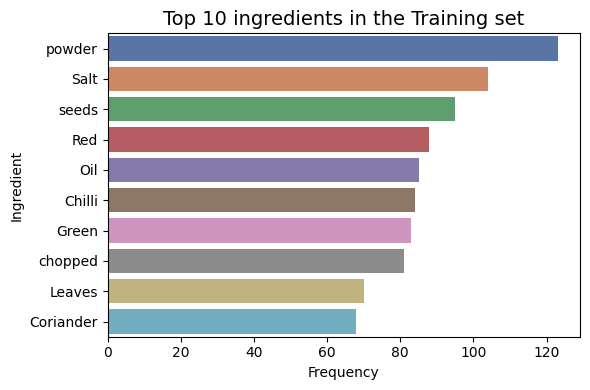

In [62]:
# plot the top frequent ingredients in training data
plot_top_items(ingredient_top_items_train,"ingredient","Training")

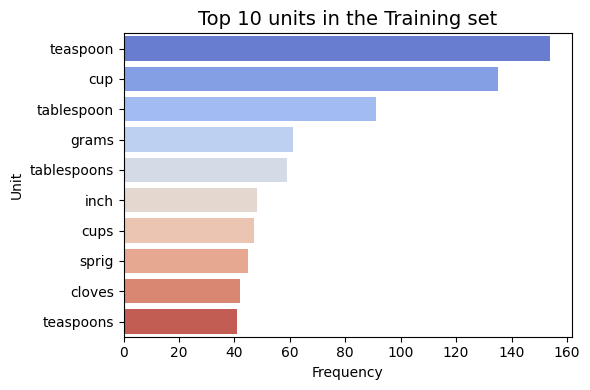

In [63]:
# plot the top frequent units in training data
plot_top_items(unit_top_items_train,"unit","Training")

### EDA Insights from Training Dataset

1.  **“powder”** and **“Salt”** are the most dominant ingredients 
       - The token **“powder”** (as part of “Turmeric powder”, “Coriander Powder”) appears **123** times—making it the single most frequent ingredient token.  
       - **“Salt”** is a close second with **104** occurrences, which is quite understandable for any recipe dataset.

2. **Spice-related seeds are very common**  
   - The token **“seeds”** (95) is the third most frequentingredients like “Cumin seeds”, “Mustard seeds”, etc., indicating a heavy reliance on whole spices.


3. **Units reflect small-scale measurements**  
   - **“teaspoon”** (154) and **“cup”** (135) far outstrip other units—these two alone account for nearly 50% of all unit mentions, highlighting that most recipes call for teaspoon- or cup-level measurements.  
   - **“tablespoon”** (91) is the third most common, while larger or less-common measures like “inch” (48) or “sprig” (45) appear far less frequently.

These patterns show that in this recipe dataset:

- **Spice powders** and **salt** are the most commonly used ingredients. This shows that the given recipe dataset is for a spice focused cooking.
- **Descriptive tokens** (e.g., “chopped”, “red”) are treated as ingredients in the NER labels, reflecting the need to capture both **food items** and **preparation cues**.
- **Small-quantity units** dominate, which is typical for spice-focused cooking.


## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [64]:
# initialise the dataset_name
X_val_flat, y_val_flat = extract_and_validate_tokens(val_df, "Validation")
ingredient_val,unit_val,quantity_val = categorize_tokens(X_val_flat,y_val_flat)

Extracting the Validation Tokens
Validation input token count : 2955
Validation POS tag count     : 2955
Validating Validation Tokens
Token lengths match.

🔹 Sample from Validation data (first 10 tokens):
1          -- quantity
cup        -- unit
Cabbage    -- ingredient
Patta      -- ingredient
Gobi       -- ingredient
Muttaikose -- ingredient
Spinach    -- ingredient
Fresh      -- ingredient
Pomegranate -- ingredient
Fruit      -- ingredient


In [69]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
ingredient_top_items_val = get_top_frequent_items(ingredient_val,"ingredient","Validation")
print('\n')
unit_top_items_val =get_top_frequent_items(unit_val,"unit","Validation")

Top 10 frequent ingredients in the Validation set:
powder          : 59
Salt            : 44
Oil             : 36
chopped         : 34
Green           : 32
Red             : 31
Chilli          : 29
Coriander       : 29
seeds           : 29
Sunflower       : 26


Top 10 frequent units in the Validation set:
teaspoon        : 66
cup             : 57
tablespoon      : 39
tablespoons     : 34
cups            : 27
inch            : 23
grams           : 21
sprig           : 16
teaspoons       : 15
cloves          : 12


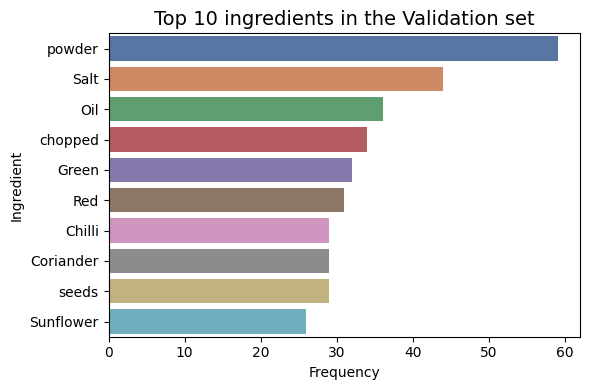

In [70]:
# plot the top frequent ingredients in validation data
plot_top_items(ingredient_top_items_val,"ingredient","Validation")

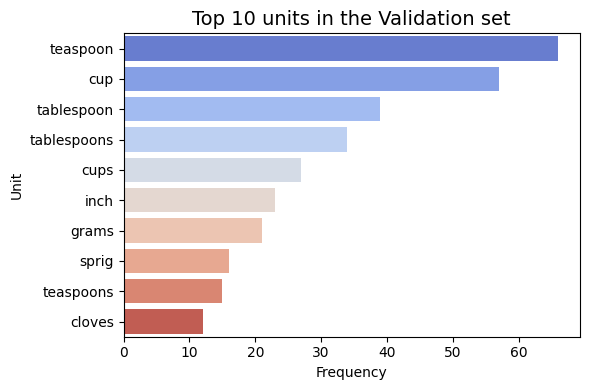

In [71]:
# plot the top frequent units in training data
plot_top_items(unit_top_items_val,"unit","Validation")

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [73]:
# Unit keywords (lowercase)
unit_keywords = {
    "tablespoon", "tablespoons", "tbsp", "teaspoon", "teaspoons", "tsp",
    "spoon", "spoons", "cup", "cups", "ml", "liter", "gms", "gram", "grams",
    "inch", "inches", "thick", "thin", "drops","kg",
    "scoops", "wedges","Spoon","Spoons","finely"
}
#"long", ,  "fistful" ,"Cut","Stalks","bud","small","clove","handful"
# Quantity keywords
quantity_keywords = {
    "half", "quarter", "third", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
    "small","pinch","little","medium","a","finely"
}
#,"finely","bunch","handful" ,"A","few"

quantity_pattern = re.compile(r"""
    (?:
        \d+-\d+\s*/\s*\d+        |  # mixed fraction like 1-1/2
        \d+\s*/\s*\d+            |  # simple fraction like 1/2
        \d+\.\d+                 |  # decimal like 1.5
        \d+                      |  # integer like 2
        ½|¼|¾|⅓|⅔|⅛|⅜|⅝|⅞        |  # unicode fractions
        \b(?:%s)\b                  # quantity keywords
    )
""" % "|".join(map(re.escape, sorted(quantity_keywords))), re.IGNORECASE | re.VERBOSE)

In [75]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")

# Combined pattern for mixed fractions, hiphen compounds and slash-compounds

custom_token_match = re.compile(r"""
    ^\d+-\d+/\d+$           |  # 1-1/2, 3-3/4
    ^\d+-\d+$               |  # 2-3, 10-20
    ^[A-Za-z]+/[A-Za-z]+$   |  # Pods/Seeds, Salt/Sugar
    ^[A-Za-z]+-[A-Za-z]+$      # tomato-puree
""", re.VERBOSE)

# Set the token_match rule
nlp.tokenizer.token_match = custom_token_match.match

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [76]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

# Process the entire sentence with spaCy
def word2features(sent, i):
    
    token = sent[i]
    word = token.text.lower()
    
    # --- Core Features ---
    features = {
        'bias': 1.0,
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': bool(token.is_stop),
        'is_digit': bool(token.is_digit),
        'has_digit': bool(any(char.isdigit() for char in word)),
        'has_alpha': bool(any(char.isalpha() for char in word)),
        'hyphenated': bool('-' in word),
        'slash_present': bool('/' in word),
        'is_title': bool(token.is_title),
        'is_upper': bool(token.is_upper),
        'is_punct': bool(token.is_punct),
        'class_weight': 1.0,    #-------- For applying weight dictionery
        
         # --- Improved Quantity & Unit Detection ---
        'is_quantity': bool(quantity_pattern.fullmatch(token.text)) or bool(word in quantity_keywords),
        'is_unit': bool(word in unit_keywords),
        'is_numeric': bool(token.like_num),
        'is_fraction': bool('/' in word),
        'is_decimal': bool('.' in word),

        # Neighbors
        'preceding_word': sent[i-1].text.lower() if i > 0 else '',
        'following_word': sent[i+1].text.lower() if i < len(sent)-1 else '',
    }

    # --- Contextual Features ---
    if i > 0:
        prev = sent[i - 1]
        prev_word = prev.text.lower()
        features.update({
            'prev_token': prev_word,
            'prev_is_quantity': bool(quantity_pattern.fullmatch(prev.text)) or prev_word in quantity_keywords,
            'prev_is_digit': prev.is_digit,
        })
    else:
        features['BOS'] = True

    if i < len(sent) - 1:
        next_ = sent[i + 1]
        next_word = next_.text.lower()
        features.update({
            'next_token': next_word,
            'next_is_unit': next_word in unit_keywords,
            'next_is_ingredient': not (next_word in unit_keywords or next_word in quantity_keywords or bool(quantity_pattern.fullmatch(next_.text))),
        })
    else:
        features['EOS'] = True

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [77]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [78]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
# Parse input tokens as spaCy docs for X_train and X_val
def clean_parentheses(text):
    return re.sub(r'\(([^()]*)\)', r'\1', text) # Removing the paranthesis so that spacy will not convert them as a separate token

X_train_docs = [nlp(clean_parentheses(" ".join(tokens))) for tokens in X_train]
X_val_docs = [nlp(clean_parentheses(" ".join(tokens))) for tokens in X_val]

# Convert to feature sets
X_train_features = [sent2features(doc) for doc in X_train_docs]
X_val_features = [sent2features(doc) for doc in X_val_docs]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [79]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [labels for labels in y_train]
y_val_labels = [labels for labels in y_val]

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [80]:
# print the length of train features and labels
print(f"Length of X_train_features: {len(X_train_features)}")
print(f"Length of y_train_labels  : {len(y_train_labels)}")

Length of X_train_features: 195
Length of y_train_labels  : 195


In [81]:
# print the length of validation features and labels
print(f"Length of X_val_features: {len(X_val_features)}")
print(f"Length of y_val_labels  : {len(y_val_labels)}")

Length of X_val_features: 84
Length of y_val_labels  : 84


In [82]:
# Verifying the count of tokenization of X_train and X_val with Spacy are matching with the correponding y_train labels and y_val labels
count = 0
for i, (x, y) in enumerate(zip(X_train_features, y_train_labels)):
    if len(x) != len(y):
        count+= 1
        print(f"Mismatch at index {i}: len(x)={len(x)}, len(y)={len(y)}")

print(f'Mismatched count between X_train_features and y_train_labels:{count}')

for i, (x, y) in enumerate(zip(X_val_features, y_val_labels)):
    if len(x) != len(y):
        count+= 1
        print(f"Mismatch at index {i}: len(x)={len(x)}, len(y)={len(y)}")

print(f'Mismatched count between X_val_features and y_val_labels:{count}')

Mismatched count between X_train_features and y_train_labels:0
Mismatched count between X_val_features and y_val_labels:0


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [83]:
# Flatten labels in y_train
y_train_flat = flatten_list(y_train)

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [85]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())  # Total number of labels (i.e., total samples)

# Print results
print("Label counts:", label_counts)
print("Total samples:", total_samples)

Label counts: Counter({'ingredient': 5203, 'quantity': 958, 'unit': 807})
Total samples: 6968


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [86]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
# Compute inverse frequency weights
weight_dict = {}
classes = np.unique(y_train_flat)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_flat)
weight_dict = dict(zip(classes, class_weights))

print("Label weight dictionary for Training:", weight_dict)

Label weight dictionary for Training: {np.str_('ingredient'): np.float64(0.4464091229418925), np.str_('quantity'): np.float64(2.4244954766875435), np.str_('unit'): np.float64(2.8781495249896736)}


In [87]:
# penalise ingredient label
weight_dict['ingredient'] *= 0.5
print("Label weight dictionary:", weight_dict)

Label weight dictionary: {np.str_('ingredient'): np.float64(0.22320456147094625), np.str_('quantity'): np.float64(2.4244954766875435), np.str_('unit'): np.float64(2.8781495249896736)}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [89]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    X_Weighted_features = []
    y_labels = []
    weights = []

    for tokens, label_seq in zip(X, y):
        doc = nlp(clean_parentheses(" ".join(tokens)))  # spaCy tokenization
        sent_features = sent2features(doc)
        sent_labels = label_seq

        sent_weights = [weight_dict.get(label, 1.0) for label in sent_labels]

        # Apply weights to the feature class_weight
        weighted_sent_features = []
        for feat_dict, weight in zip(sent_features, sent_weights):
            weighted_feats = {
                k: v * weight if (k == 'class_weight') else v
                for k, v in feat_dict.items()
            }
            weighted_sent_features.append(weighted_feats)

        X_Weighted_features.append(weighted_sent_features)
        y_labels.append(sent_labels)
        weights.append(sent_weights)

    return X_Weighted_features, y_labels, weights

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [91]:
# Apply manually computed class weights
X_train_weighted_features, y_train_labels, train_weights = extract_features_with_class_weights(X_train, y_train, weight_dict)
X_val_weighted_features, y_val_labels, val_weights = extract_features_with_class_weights(X_val, y_val, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



#####  <font color = red>  Weight dictionery has been applied during the generation of feature list </font> <br>

In [92]:
# initialise CRF model with the specified hyperparameters and use weight_dict
import sklearn_crfsuite
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.5,                  # L1 regularization
    c2=1.0,                  # L2 regularization
    max_iterations=100,
    all_possible_transitions=True 
)
crf.class_weight = weight_dict  #Applying weight_dict

# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_labels)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [93]:
# evaluate on the training dataset
y_train_pred = crf.predict(X_train_weighted_features)

In [94]:
# specify the flat classification report by using training data for evaluation
print("Flat Classification Report (Training Data):")
print(metrics.flat_classification_report(y_train_labels, y_train_pred, digits=3))

Flat Classification Report (Training Data):
              precision    recall  f1-score   support

  ingredient      1.000     1.000     1.000      5203
    quantity      0.997     0.996     0.996       958
        unit      0.995     0.998     0.996       807

    accuracy                          0.999      6968
   macro avg      0.997     0.998     0.998      6968
weighted avg      0.999     0.999     0.999      6968



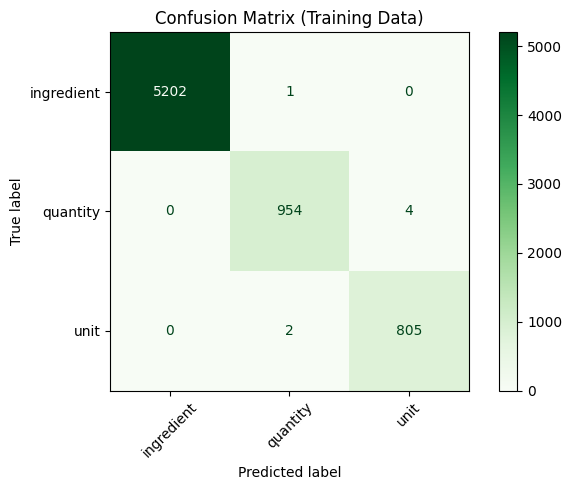

In [103]:
# create a confusion matrix on training datset
# Flatten true and predicted labels
y_train_true_flat = [label for seq in y_train_labels for label in seq]
y_train_pred_flat = [label for seq in y_train_pred for label in seq]

# Get sorted label list from training labels
labels_sorted = sorted(set(y_train_true_flat))

# Compute confusion matrix
cm = confusion_matrix(y_train_true_flat, y_train_pred_flat, labels=labels_sorted)

# Plot confusion matrix with greenish color
fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
disp.plot(ax=ax, cmap="Greens", xticks_rotation=45)

plt.title("Confusion Matrix (Training Data)")
plt.tight_layout()
plt.show()

In [105]:
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train_true_flat, y_train_pred_flat)
print(f"Overall Training Accuracy: {train_accuracy:.2%}")

Overall Training Accuracy: 99.90%


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [106]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [107]:
# predict the crf model on validation dataset
y_val_pred = crf.predict(X_val_weighted_features)

In [108]:
# specify flat classification report
print("Classification Report (Validation Set):")
print(metrics.flat_classification_report(y_val_labels, y_val_pred, digits=3))

Classification Report (Validation Set):
              precision    recall  f1-score   support

  ingredient      1.000     1.000     1.000      2172
    quantity      1.000     0.998     0.999       428
        unit      0.997     1.000     0.999       355

    accuracy                          1.000      2955
   macro avg      0.999     0.999     0.999      2955
weighted avg      1.000     1.000     1.000      2955



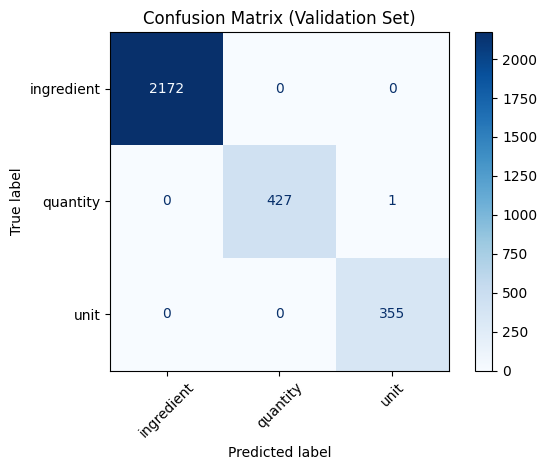

In [112]:
# create a confusion matrix on validation dataset
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]

labels_sorted = sorted(list(set(y_val_true_flat + y_val_pred_flat)))  # all unique labels
cm = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels_sorted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [113]:
# flatten Labels and Initialise Error Data
y_val_true_label_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_label_flat = [label for seq in y_val_pred for label in seq]
X_val_tokens_flat = [token for doc in X_val_docs for token in doc]
val_weights_flat = [wt for seq in val_weights for wt in seq]
error_data = []
len(y_val_true_label_flat)

2955

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [114]:
# iterate and collect Error Information
# Compute per-label accuracy
from collections import defaultdict
label_correct = defaultdict(int)
label_total = defaultdict(int)
for idx, (true_label, pred_label, token,val_weight) in enumerate(zip(y_val_true_label_flat, y_val_pred_label_flat, X_val_tokens_flat,val_weights_flat)):
    label_total[true_label] += 1
    if true_label == pred_label:
        label_correct[true_label] += 1
    if true_label != pred_label:
        # get previous and next tokens with handling for boundary cases
        prev_token = X_val_tokens_flat[idx - 1].text if idx > 0 else ""
        next_token = X_val_tokens_flat[idx + 1].text if idx < len(X_val_tokens_flat) - 1 else ""

        # Contextual info (window of 5 tokens around the error)
        context_start = max(0, idx - 2)
        context_end = min(len(X_val_tokens_flat), idx + 3)
        context = " ".join([tok.text for tok in X_val_tokens_flat[context_start:context_end]])

        # Store error data
        error_data.append({
            'token': token.text,
            'prev_token': prev_token,
            'next_token': next_token,
            'true_label': true_label,
            'pred_label': pred_label,
            'context': context,
            'class_weight': val_weight   #weight_dict.get(true_label, 0.0)
        })

            
# calculate accuracy per label
label_accuracy = {label: label_correct[label] / label_total[label]
                  for label in y_val_true_label_flat if label_total[label] > 0}

# Print per-label accuracy
for label, acc in label_accuracy.items():
    print(f"Accuracy for label '{label}': {acc:.2%}")

Accuracy for label 'quantity': 99.77%
Accuracy for label 'unit': 100.00%
Accuracy for label 'ingredient': 100.00%


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [115]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)
print(f"Total Errors Found: {len(error_df)} out of {len(y_val_true_label_flat)} flattened validation labels")

val_accuracy = accuracy_score(y_val_true_label_flat, y_val_pred_label_flat)
print(f"\nOverall Validation Accuracy: {val_accuracy:.2%}")

Total Errors Found: 1 out of 2955 flattened validation labels

Overall Validation Accuracy: 99.97%


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [122]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context
error_stats = error_df.groupby("true_label").agg(
    total_errors=("token", "count"),
    average_class_weight=("class_weight", "mean")
    
).reset_index()
error_stats["accuracy"] = error_stats["true_label"].map(label_accuracy)

print("\nError Analysis by True Label:\n")
print(error_stats)
print("\nError Details:\n")
print(error_df[['token','prev_token','next_token', 'true_label', 'pred_label', 'context']])
print("\n")


Error Analysis by True Label:

  true_label  total_errors  average_class_weight  accuracy
0   quantity             1              2.424495  0.997664

Error Details:

    token prev_token next_token true_label pred_label                             context
0  finely   Chillies    chopped   quantity       unit  Green Chillies finely chopped inch




##### Analysing the errored label 'finely' for getting some insights

In [123]:
# iterate and collect Errorred token details
finely_data = []
for idx, (true_label, pred_label, token) in enumerate(zip(y_val_true_label_flat, y_val_pred_label_flat, X_val_tokens_flat)):
    if token.text == 'finely':
        # get previous and next tokens with handling for boundary cases
        prev_token = X_val_tokens_flat[idx - 1].text if idx > 0 else ""
        next_token = X_val_tokens_flat[idx + 1].text if idx < len(X_val_tokens_flat) - 1 else ""

        # Contextual info (window of 5 tokens around the error)
        context_start = max(0, idx - 2)
        context_end = min(len(X_val_tokens_flat), idx + 3)
        context = " ".join([tok.text for tok in X_val_tokens_flat[context_start:context_end]])

        # Store error data
        finely_data.append({
            'token': token.text,
            'prev_token': prev_token,
            'next_token': next_token,
            'true_label': true_label,
            'pred_label': pred_label,
            'context': context
            
        })
finely_df = pd.DataFrame(finely_data)
print(finely_df[['token','prev_token','next_token', 'true_label', 'pred_label', 'context']])

     token prev_token next_token  true_label  pred_label                                   context
0   finely   Tomatoes    chopped  ingredient  ingredient            2 Tomatoes finely chopped inch
1   finely      onion    chopped  ingredient  ingredient               peas onion finely chopped 3
2   finely     Garlic    chopped  ingredient  ingredient            cloves Garlic finely chopped 2
3   finely      bunch       Mint  ingredient  ingredient                a bunch finely Mint Pudina
4   finely   Chillies    chopped  ingredient  ingredient     Green Chillies finely chopped Shallot
5   finely      Onion    chopped  ingredient  ingredient             grated Onion finely chopped 2
6   finely   Chillies    chopped  ingredient  ingredient       Green Chillies finely chopped Onion
7   finely     onions    chopped  ingredient  ingredient                 2 onions finely chopped 4
8   finely   Chillies    chopped  ingredient  ingredient           Green Chillies finely chopped 1
9   finely

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




  <font color = blue>
      
   1.  The model could predict the labels correctly  for the validation data with an accuracy rate of **99.97%** and errored only **0.03%**
   2.  Out of 2955 flattened labels, only **1 token** was errored for the label **'quantity'**, the accuracy percentage of the errored label is **99.77%**.
   3.  The accuracy for each unique label is:
          Accuracy for label **'quantity'**: **99.77%**
          Accuracy for label **'ingredient'**: **100.00%**
          Accuracy for label **'unit'**: **100.00%**
   4.  The label 'finely' which is a 'quantity' true label is predicted as 'unit'
   5.  Out of 24 occurances of the token 'finely', 21 times it is defined as ingredient which are predicted correctly as 'ingredient', out of 2 times it is defined as 'unit', they too predicted correctly. However the token 'finely' in the context of 'finely chopped', the model predicted it as 'unit' instead of predicting as 'quantity'. Since the token 'finely' is rarely defined as 'quantity', instead of ingredient, this error can be ignored.
 
  </font>

# **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

The model achieved training accuracy of **99.91%** and a validation accuracy of **99.97%**. So the model is a good fit.